In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2022/lesson3')

Mounted at /content/drive


## Overnight Index Swap

* Interest rate swaps (IRS) are usually used to mitigate the risks of fluctuations of varying interest rates, or to benefit from lower rates. 

* An Overnight Index Swap (OIS) is a particular kind of IRS which pays a floating coupon, determined a pre-determined index of a daily overnight reference rate (e.g €STR), against a fixed coupon.  

* An OIS is defined by:
  * a notional amount $N$;
  * a starting date $d_0$;
  * a sequence of payment dates $d_1,...,d_n$;
  * a fixed rate $K$.

* For simplicity in the following we assume the fixed and floating legs to have the same notional and payment dates, although this is not necessarily always the case in practice.


### OIS Valuation

* To evaluate the NPV of such products it is necessary to sum the discounted values of each leg cash flows (full derivation in the notes)

<center>
<table style="border: 1px solid black;">
    <tr>
        <th width=350px style="text-align:center">Floating Leg</th><th width=350px style="text-align:center">Fixed Leg</th>
    </tr>
    <tr>
        <td style="border: 1px solid black;">$$\mathrm{NPV}_{\mathrm{float}} = N \cdot [D_{\mathrm{OIS}}(d_0) - D_{\mathrm{OIS}}(d_n)]$$</td>
        <td style="border: 1px solid black;">$$\mathrm{NPV}_{\mathrm{fixed}} = N\cdot K\cdot \sum_{i=1}^{n}D_{\mathrm{OIS}}(d_{i})\frac{d_i - d_{i-1}}{360}$$</td>
    </tr>
</table>
</center>

* where $D_{\mathrm{OIS}}(d)$ is the discount factors implied by OIS prices (**we will see how to derive it**).

* We will always look at these products from the point of view of the **receiver of the floating leg**

$$\mathrm{NPV}_{\mathrm{OIS}} = \mathrm{NPV}_{\mathrm{float}} - \mathrm{NPV}_{\mathrm{fixed}}$$

* The $\frac{1}{360}$ fraction appears because €STR rates are quoted using the ACT/360 day-count convention 
  * other currencies might have different conventions;  
  * in addition we are making the simplifying assumption of ignoring weekends and holidays: each overnight rate is valid for only one day.

### OvernightIndexSwap Class

* Let's write a class to represent OIS and compute its value given a specific discount curve
    * attributes: start_date, nominal, fixed leg rate and payment dates;
    * methods: two to compute NPVs of floating and fixed legs respectively and one to compute the swap value. 

In [ ]:
# define OIS class
from finmarkets import generate_dates


#### Example

* Let's test the class with this [discount curve](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/discount_factors_2022-10-05.xlsx) and a swap with $N=1M$, 36 months maturity, fixed rate 2.5% and starts on 2020-10-21.

In [ ]:
# test the class
import pandas as pd
from datetime import date
from finmarkets import DiscountCurve
from dateutil.relativedelta import relativedelta


## Discount Factor Determination from Market Quotes (Bootrstap)

* Our ultimate goal is to take a series of Overnight Index Swap quotations, and determine the discount factors implied by their prices. 

* The employed technique is called **bootstrap**: this is the ABC of financial mathematics, since you always need a discount curve to price a contract
  * we concentrate on €STR swaps in order to build an EUR discount curve.

* The asumption underlying bootstrap is that market quotes represent the **fair** prices of the OIS:
  * by fair price we mean an estimate of what a willing buyer would pay a willing seller for a given asset, assuming both have a reasonable knowledge of the asset's worthness;
  * by defintion market quotes make the swap NPVs null.

### The Algorithm

* In finance, *bootstrap* is a method for constructing a yield curve from the prices of a set of coupon-bearing products (e.g. bonds and swaps)
  * using only few selected products, it is possible to derive rates for all possible maturities.
* The term structure of spot rates is obtained from the yields by *forward substitution*, in other words by solving for them recursively. 

#### Example

* Consider five bonds (yearly fixed coupon of 4\%, 5\%, 6\%, 7\% and 8\% respectively) with maturities ranging from 1 to 5 years, each having a value of €100 and **traded at par** (traded at its face value). 

* To determine the yield curve proceed as follows:
  1. at the end of first year the discounted cash flow of the first bond is €104 (principal + coupon) times the discount factor, so the implied 1 year rate can be found by solving

$$100 = \cfrac{104}{(1 + r_{1y})}\implies r_{1y} =  104/100 - 1 = 4\%$$

  2. at the end of second year the sum of the cash flows of the second bond can be compared to its trading price to compute the 2-year spot rate $r_{2y}$ (using the previously derived value of $r_{1y}$)

$$100 = \cfrac{5}{(1 + r_{1y})} + \cfrac{105}{(1 + r_{2y})^{2}}$$
<br>
$$
100 = 5 / (1 + 0.04) + 105 / (1 + r_{2y})^{2}\qquad\Rightarrow\qquad r_{2y}^2  + 2 r_{2y}  - 0.103030 = 0 $$

* This second order equation can be solved either by hand or with `numpy.roots`.

$$r_{2y} = - 1 \pm \sqrt{1 + 0.103030} = \begin{cases}-2.05023 \\ 0.0502\end{cases}$$


In [ ]:
import numpy as np

* From the third year on we get equation of third order (or more) which are not easily analitically solvable. 
  
* For example the equation for the fifth bond at the fifth year:

$$100 = \cfrac{8} {(1 + r_{1y})} + \cfrac{8} {(1 + r_{2y})^{2}}+ \cfrac{8} {(1 + r_{3y})^{3}} + \cfrac{8} {(1 + r_{4y})^{4}} + \cfrac{108} {(1 + r_{5y})^{5}}$$

* Assuming we have already determined the previous rates:

<center>

| years | coupon rate | bond price | rate|
|:----:|:----:|:----:|:----:|
|1 | 1.00 % | 100 | 4.00% |
|2 | 2.00 % | 100 | 5.02% |
|3 | 3.00 % | 100 | 6.08% |
|4 | 4.00 % | 100 | 7.19% |
|5 | 5.00 % | 100 | ??? |

![](https://drive.google.com/uc?id=1AmCejDf3ifMz9Zc6XOHeAk-5Tc23Zbrw)

</center>

* Solving the previous equation means to find its zeros: the values of $\hat{x}$ for which $f(\hat{x})=0$.

* There are various methods to solve this problem (which is also called root-finding), the simplest being the **bisection method**.

<center>

![](https://drive.google.com/uc?id=1Zt18h9fRo65Er5V9iJBdOpX4trcytLSW)

</center>

* In `python` this algorithm is implemented in `scipy.optimize.bisect`.

In [ ]:
# find zeros of previous eq. with bisect (0, 1)
from scipy.optimize import bisect


* An interesting alternative is the **Brent method** available in `scipy.optimize.brentq`.

In [ ]:
# find zeros of previous eq. with brentq
from scipy.optimize import brentq


* The very same mechanism can be generalized to more maturities to get a more detailed yield curve: 

$$\begin{equation*}
\begin{cases}
f_1(r_1, p_1) = 0 \\
f_2(r_1, r_2, p_2) = 0 \\
f_3(r_1, r_2, r_3, p_3) = 0 \\
f_4(r_1, r_2, r_3, r_4, p_4) = 0 \\
\cdots
\end{cases}
\end{equation*}
$$
* where $r_i$ are the unknown spot rates and $p_i$ the market quotes of the considered products. 

* The iterative procedure we have applied before exploits the first equation to find $r_1 = f_1^{-1}(p_1)$, the second to find $r_2 = f_2^{-1}(r_1, p_2)$ and so on...

## Bootstrap as Minimization Problem

* The previous algorithm can be simplified (and automitized) by seeking for a particular vector of rates $\mathbf{\hat{r}} = (\hat{r_1}, \hat{r_2}, \hat{r_3},\ldots)$ which solves the following equation:

$$F = f_1^2(\hat{r}_1,p_1) + f_2^2(\hat{r}_1, \hat{r}_2,p_2) + f_3^2(\hat{r}_1, \hat{r}_2, \hat{r}_3,p_3) + f_4^2(\hat{r}_1, \hat{r}_2, \hat{r}_3, \hat{r}_4,p_4) + \ldots = 0$$

* Under this terms the bootstrap technique can be considered as a **minimization problem**;
  * we need to find $\mathbf{\hat{r}}$ which makes $F$ as close as possible to 0;
  * notice that each $f_i$ is squared since we want all of them to be minimized at the same time and not only $F$ globally (without the squared there may be cancellation effects between the terms of the sum).


### Minimization Algorithm

* Let's see how a minimization algorithm works looking at a practical example.
* Find the dimensions that will minimize the costs to manufacture a cylindrical can of volume $330~\mathrm{cm}^3\;(33~\mathrm{cl})$:
  * **cheaper can -> less aluminum -> smaller surface given the volume**

<center>

![](https://drive.google.com/uc?id=1LQaX8j10nq1KgRu4RdR4Ade96fsMNxa6)

</center>

$$ S(r, h) = 2\pi rh + 2\cdot(\pi r^2) $$

* The volume is fixed to $330~\mathrm{cm}^3$ so we can remove $h$ from the previous equation:

$$ V = \pi r^2 h = 330\quad\implies h = \cfrac{330}{\pi r^2} $$

* The surface function to be minimized is:

$$ S(r) = 2\pi rh + 2\cdot(\pi r^2) = \cfrac{2\cdot 330}{r} + 2\cdot(\pi r^2)$$


   1. define an *objective function* i.e. the function that is actually minimized to reach our goal (in this example the can area function);

In [ ]:
# define objective function
from math import pi


  2. set the initial value of the unknown parameters and their range of variability; we are going to start with $r=1~\mathrm{cm}$ and let it varies between $1~\textrm{mm}$ and $1~\textrm{m}$;


3. Finally run the algorithm (it is defined in `scipy.optimize.minimize`):
  * compute the objective function value;
  * move the parameter values ($r$ in our example) to find a smaller value of the objective function (e.g. following the derivative direction w.r.t. each parameter); in case constraints are defined, they will be considered when the parameter values are varied;
  * repeat until further variations of the values won’t change significantly the objective function (i.e. we have found a minimum of the function so the minimization process is completed !).

In [ ]:
from scipy.optimize import minimize


<center>

![](https://drive.google.com/uc?id=1pd9XoqgZY1iXcpuev7e2K4tChSw2TApw)

</center>

<center>

![](https://drive.google.com/uc?id=1-0_XqAuVDJte0Ft3dCNFJBTBfZQbNF_D)

</center>

1.0

100.0

19.397339965049717 

6.595008018080359 

4.298586253085182 

3.892925184969328

3.7244568122451653

3.7457387384265766

3.7449429028886034 

3.7449385393372294

### Local Minima Issue

In [ ]:
import numpy as np
from math import pi

def func(x):
    return np.cos(3*pi*x)/x

<center>

![](https://drive.google.com/uc?id=1NarHa2FYJxDT6nq_sm6H57PUJcwHBxxx)

</center>

In [ ]:
from scipy.optimize import minimize
x0 = [1.1]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-1.00569871])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.44089208e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.98865633])


In [ ]:
from scipy.optimize import minimize
x0 = [0.5]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-3.17151711])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.8817842e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.29691798])


## Back to OIS Bootstrap

* In the latter formulation we gave bootstrap requires to minimize simultaneously the NPV's of a set of OIS;

$$\begin{equation}
\mathrm{Objective Function} =	f_1^2(\hat{r}_1,p_1) + f_2^2(\hat{r}_1, \hat{r}_2,p_2) + \ldots =\sum_{i=1}^{n}\mathrm{NPV}^\mathrm{OIS}_i(\mathcal{C})^2
\end{equation}$$

* The only unknown parameter of each NPV is the discount curve $\mathcal{C}$ (i.e. **the algorithm will adjust the unknown discount factors of $\mathcal{C}$ to reach the minimum**).
  * In the previous example there was a single parameter involved in the minimization i.e. the can radius.
  * A discount curve is characterized by pillar dates ($\mathbf{d}$) and discount factors ($\mathbf{x}$):
      * we haven't yet identified a constraint on how many points the curve needs to be made of (*too many or too few points may prevent us from finding the solution*).
  * **It makes sense to choose the number of parameters (degrees of freedom) to match the number of market quotes** (set the pillar dates equal to the set of the swap expiry dates).

$$\begin{equation}
 \mathrm{min}_{\mathbf{x}} \left\{\sum_{i=1}^{N}\mathrm{NPV}^\mathrm{OIS}_i( \mathcal{C}(\mathbf{x}))^2\right\}
\end{equation}$$

* First create the swaps according to the available market quotes:

<center>

![](https://drive.google.com/uc?id=1U8N-S6-eWAV56cKay8scaUBSR6GeEJLP)

</center>

The file can be downloaded from here: [ois_2022_09_30.xlsx](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_2022_09_30.xlsx)



In [ ]:
# read quotes
import pandas as pd


* **Be careful when doing this operation and double check the units of rates, quotes, etc... (for example in this case quotes are expressed in percent so you need to multiply by 0.01 before using them).**

In [ ]:
# creates the OIS from market quotes 'make_swaps'
from finmarkets import generate_dates
from datetime import date
from dateutil.relativedelta import relativedelta


* Set the initial value of the discount factors ($x_i$) to .5 with a range of variability $[0.01, 10]$. Remember that "today's" discount factor is just 1.

In [ ]:
# set boundaries and guess values
import numpy as np


* Define the objective function: the sum of the squared NPVs of the OIS 

$$\begin{equation}
\sum_{i=1}^{N}\mathrm{NPV}^\mathrm{OIS}_i( \mathcal{C}(\mathbf{x}))^2
\end{equation}
$$

In [ ]:
# define objective function
from finmarkets import DiscountCurve


* Launch the minimizer to find the discount factors ($\mathbf{x}$)

### `args` and `kwargs`

* `args` and `kwargs` represent two useful ways of passing parameters to a function that is called by another function.

In [ ]:
args = (1, 2, 3)
print ("a={} b={} c={}".format(args[0], args[1], args[2]))
print ("a={} b={} c={}".format(*args))

a=1 b=2 c=3
a=1 b=2 c=3


In [ ]:
def runner(f, x, args):
    return f(x, *args)*2

def func(x, a, b, c):
    return a*x**2 + b*x + c

for v in range(3):
    print (runner(func, 2, args=(v, 1, 5)))

14
22
30


* `kwargs` works like `args` except that you have to pass a dictionary with as keys the names of the parameters. Also to expand it you have to use the double-star operator.

In [ ]:
def runner(f, x, kwargs):
    return f(x, **kwargs)*2

def func(x, a, b, c):
    return a*x**2 + b*x + c

for v in range(3):
    print (runner(func, 2, kwargs={"a":v, "c":5, "b":1}))

14
22
30


In [ ]:
# minimize
from scipy.optimize import minimize


* Some diagnostic numbers.

In [ ]:
# print initial and final objective function values


* Finally we can create the discount curve implied by the market quote of our swaps. 

$$ \mathrm{df} = e^{-rt} \quad\implies \mathrm{log(df)} = -rt\quad\implies r = -\mathrm{log(df)}/t$$

In [ ]:
# create the discount curve with our factors
from math import log
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve


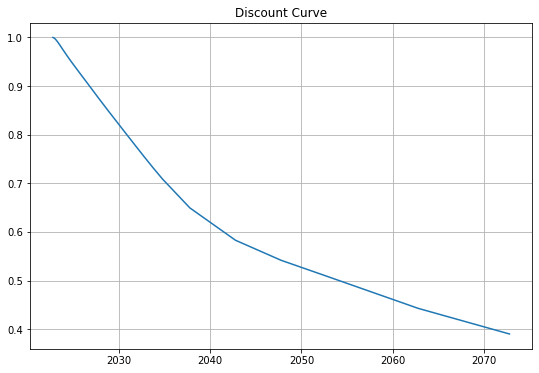

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(pillars, dfs)
plt.title("Discount Curve")
plt.grid(True)
plt.show()

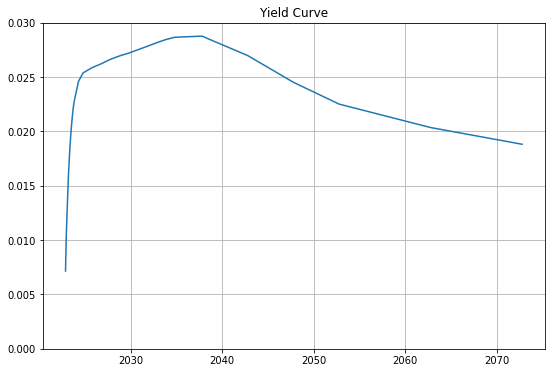

In [ ]:
from matplotlib import pyplot as plt
rs = [-log(estr.df(d))/((d-pillars[0]).days/365) for d in pillars[1:]]
plt.plot(pillars[1:], rs)
plt.ylim(0.0, 0.03)
plt.title("Yield Curve")
plt.grid(True)
plt.show()

Try to repeat the same exercise with Overnight Swaps quotes from last year [ois_2021_10_14.xlsx](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_2021_10_14.xlsx) and then compare discount and yield curves.

In [ ]:
# implement the same minimization as before using the 2021 input file instead
import pandas as pd


In [ ]:
plt.plot(pillars, dfs, color='blue', label='Oct 2022')
plt.plot(pillars_old, dfs_old, color='red', label='Oct 2021')
plt.title("Discount Curve")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
rs_old = [-log(dc_old.df(d))/((d-pillars_old[0]).days/365) for d in pillars_old[1:]]
plt.plot(pillars[1:], rs, color='blue', label='Oct 2022')
plt.plot(pillars_old[1:], rs_old, color='red', label='Oct 2021')
plt.hlines(0, pillars[1], pillars[-1], linestyle="--")
plt.ylim(-0.007, 0.03)
plt.xlim(pillars[0], pillars[-1])
plt.title("Yield Curve")
plt.grid(True)
plt.legend()
plt.show()